In [28]:
# default_exp fontstats
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Font Statistics

Tools for calculating statistics about fonts, e.g. glyph dimensions, and loaders for already calculated statistics.

In [167]:
#export
from aifont.core import *
from aifont.fontsampler import *
from aifont.ocrlearner import *
from collections import OrderedDict
from enum import Enum, auto
from fastai.data.all import *
from fastai.vision.all import *
import gc
from itertools import combinations
from nbdev.showdoc import *
import pandas as pd
from pandas import DataFrame
import PIL
from PIL import ImageFont
import pydiffvg
import torch
from typing import Callable, List, Protocol, Tuple, Union

## Constants

In [76]:
#export

GOOGLE_FONTS_LETTER_WIDTHS_PATH = f"{GOOGLE_FONT_ROOT_PATH}/google-fonts-letter-widths.csv"
TMNIST_STATS_PATH = "data/94_character_TMNIST_glyph_dims.csv"


## Character dimensions from the TMNIST dataset

Calculate character widths in fonts to see if there is an order into which they fall. Note that these measurements will probably be skewed because of the presence of serif (and display) fonts. The serifs will increase the measured widths for some glyphs but not all. To correct for that, see below for another solution using FontSampler.

In [6]:
#export

def calc_glyph_dimensions(
    df: DataFrame = None,
    report_every = 100
    ) -> DataFrame:
    """Return a DataFrame that contains the bounding box data for each glyph,
       as well as font name, letter index in vocab and letter string but not
       the pixel values."""
    if df is None: df = get_tmnist_images(undersample=False, drop_extra_cols=False)
    n_rows = len(df)
    px_cols = int(df.columns[-1])
    px_size = float(math.sqrt(px_cols))
    glyph_bounds = np.empty((n_rows, 6))
    for i in range(n_rows):
        if i % report_every == 0: print(f"Processing row {i + 1} of {n_rows}...")
        lft, top, rgt, btm = px_size + 1, px_size + 1, -1., -1.
        for j in range(0, px_cols):
            # Check if pixel at j is not white and use the grey level
            # to calculate an approximation of the subpixel position
            # which ranges from 0 to size
            # NB. reverse values; pixel col names start from 1
            v = df.iloc[i][str(j + 1)]
            if v > 0.1:
                fr = v / 255
                row_n = j // px_size
                col_n = j % px_size
                if row_n < top: top = row_n + 1 - fr
                if row_n > btm: btm = row_n + fr
                if col_n < lft: lft = col_n + 1 - fr
                if col_n > rgt: rgt = col_n + fr
        glyph_bounds[i] = rgt - lft, btm - top, lft, top, rgt, btm
    # Create return df
    print("Creating statistics DataFrame")
    norm_cols = ["width_norm", "height_norm"]
    dim_cols = ["width", "height", "left", "top", "right", "bottom"]
    meta_cols = ["names", "labels", "labels_num"]
    col_order = meta_cols + norm_cols + dim_cols
    res = DataFrame(glyph_bounds)
    res.columns = dim_cols
    res.index = df.index
    for c in meta_cols:
        res[c] = df[c]
    res.sort_values(by=["names", "labels_num"], inplace=True)
    # Calc normalised values
    means = res.groupby(["names"]).mean()
    stds = res.groupby(["names"]).std()
    norms = np.empty((n_rows, 2))
    for i in range(n_rows):
        r = res.iloc[i]
        norms[i] = [(r[x] - means.loc[r.names][x]) / (stds.loc[r.names][x] + 1e-8) for x in ("width", "height")]
    res["width_norm"]  = norms[:, 0]
    res["height_norm"] = norms[:, 1]
    res = res[col_order]
    return res

# df = get_tmnist_images(undersample=False, drop_extra_cols=False)
# glyph_dimensions = calc_glyph_dimensions(df)
# glyph_dimensions.to_csv(TMNIST_STATS_PATH)
glyph_dimensions = pd.read_csv(TMNIST_STATS_PATH)
glyph_dimensions.head()

,Unnamed: 0,names,labels,labels_num,width_norm,height_norm,width,height,left,top,right,bottom
0,53592,ABeeZee-Italic,A,0,0.606230,0.274584,17.086275,19.031373,4.968627,4.000000,22.054902,23.031373
1,208382,ABeeZee-Italic,B,1,-0.442801,-0.216177,14.294118,18.407843,7.815686,4.776471,22.109804,23.184314
2,153646,ABeeZee-Italic,C,2,-0.526782,-0.308774,14.070588,18.290196,9.933333,4.996078,24.003922,23.286275
3,227610,ABeeZee-Italic,D,3,-0.061201,-0.234696,15.309804,18.384314,6.823529,4.792157,22.133333,23.176471
4,141130,ABeeZee-Italic,E,4,-0.273365,0.836336,14.745098,19.745098,9.254902,4.000000,24.000000,23.745098


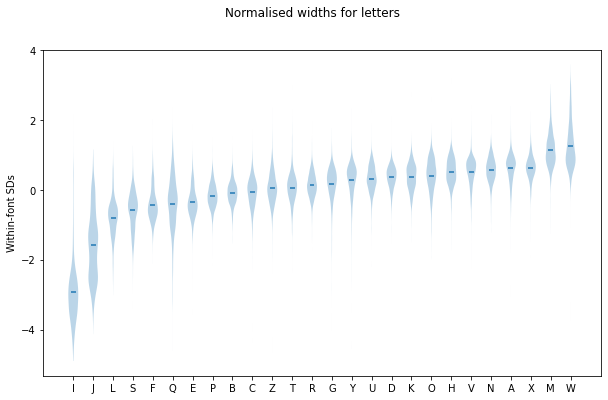

In [7]:
def plot_normalised_glyph_dims(
    glyph_dimensions: DataFrame,
    figsize=(10, 6)
    ) -> None:
    """Plot the normalised glyph dimensions in a violin plot."""
    letters = list(glyph_dimensions.labels.unique())
    letter_means = glyph_dimensions.groupby(["labels"]).mean()
    letters.sort(key = lambda x: letter_means.loc[x].width_norm)
    data = [glyph_dimensions[glyph_dimensions.labels == x].width_norm for x in letters]
    ticks = list(range(1, len(letters) + 1))
    fig, ax = plt.subplots(figsize=figsize)
    vp = ax.violinplot(data, ticks, showmeans=True, showmedians=False, showextrema=False)
    fig.suptitle(f"Normalised widths for letters")
    ax.set_ylabel("Within-font SDs")
    ax.set_xticks(ticks, letters)
    plt.show()

plot_normalised_glyph_dims(glyph_dimensions, (10,6))

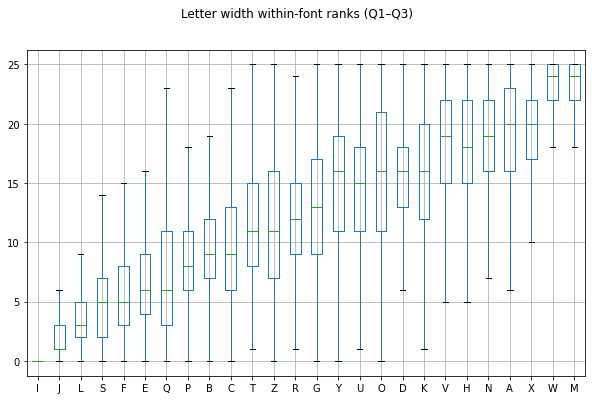

In [22]:
def calc_glyph_width_ranks_old(
    glyph_dimensions: DataFrame,
    plot = True,
    figsize=(10, 6)
    ) -> DataFrame:
    """Calculate the within-font width orders for each letter in each font
       and plot the orders in a violin plot."""
    fonts     = list(glyph_dimensions.names.unique())
    letters   = list(glyph_dimensions.labels.unique())
    n_fonts   = len(fonts)
    n_letters = len(letters)
    letter_ranks = np.empty((n_fonts, n_letters))
    for i, f in enumerate(fonts):
        dff = glyph_dimensions[glyph_dimensions.names == f]
        ord = list(dff.sort_values(by="width_norm").labels)
        ranks = [ord.index(x) if x in ord else None for x in letters]
        letter_ranks[i] = ranks
    res = DataFrame(letter_ranks)
    res.index = fonts
    res.columns = letters
    if plot:
        letter_order = list(res.columns)
        means = res.mean()
        letter_order.sort(key=lambda x: means[x])
        fig = plt.figure(figsize=figsize)
        res[letter_order].boxplot(showfliers=False)
        fig.suptitle(f"Letter width within-font ranks (Q1–Q3)")
        plt.show()
    return res

glyph_ranks = calc_glyph_width_ranks_old(glyph_dimensions)

## Character Dimension Stats for Google Fonts

Calculating character dimensions stats using `FontSampler`, so we can restrict the sample to regular-width sans-serif fonts.

> NB! The functions below expect a more practical form of DataFrame of the shape (fonts, characters).

In [77]:
#export

def calc_glyph_widths_with_font_sampler(
    size = 256,
    category="sans-serif", 
    variants=["regular", "medium"], 
    subsets=["latin"],
    vocab = VOCAB_UC
    ) -> DataFrame:
    text_size = size // 2
    fs = FontSampler(category=category, variants=variants, subsets=subsets)
    n_fonts = fs.num_fonts
    n_letters = len(vocab)
    res = np.empty((n_fonts, n_letters))
    font_names = [None] * n_fonts
    for i in range(n_fonts):
        if i % 20 == 0: print(f"Font {i + 1} of {n_fonts}")
        # We can't use the getsize method as it includes padding
        # widths = np.array([font.getsize(l)[0] for l in vocab])
        widths = []
        for l in vocab:
            # Render and transpose
            rend, font_name = fs.render_text(l, text_size, font_index=i, image_width=size, image_height=size,
                                             include_font=True, as_normalised_array=True)
            rend = rend.T
            left, right = size, -1
            for c in range(0, size):
                # Check if any value in column is non-zero
                if np.greater(rend[c], .5).any(): left = c; break
            for c in range(left, size):
                v = size - c - 1
                if rend[v].any(): right = v; break
            widths.append(right - left if right > -1 else None)
        res[i] = widths
        font_names[i] = font_name
    res_df = DataFrame(res)
    res_df.columns = vocab
    res_df.index = font_names
    return res_df

# glyph_widths = calc_glyph_widths_with_font_sampler()
# glyph_widths.to_csv(GOOGLE_FONTS_LETTER_WIDTHS_PATH)
glyph_widths = pd.read_csv(GOOGLE_FONTS_LETTER_WIDTHS_PATH)
glyph_widths.head()

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
IBMPlexSansKR-regular.ttf,75.0,59.0,65.0,61.0,51.0,47.0,72.0,66.0,35.0,50.0,...,76.0,57.0,61.0,67.0,64.0,71.0,107.0,71.0,71.0,63.0
DMSans-medium.ttf,79.0,61.0,81.0,71.0,55.0,51.0,84.0,70.0,13.0,53.0,...,89.0,59.0,63.0,65.0,69.0,81.0,120.0,71.0,72.0,57.0
SairaSemiCondensed-regular.ttf,69.0,53.0,47.0,53.0,43.0,39.0,57.0,59.0,10.0,25.0,...,63.0,53.0,55.0,57.0,58.0,66.0,101.0,68.0,65.0,55.0
Sarabun-medium.ttf,73.0,55.0,67.0,59.0,51.0,51.0,70.0,67.0,13.0,47.0,...,76.0,55.0,59.0,68.0,65.0,74.0,101.0,71.0,71.0,65.0
AsapCondensed-regular.ttf,60.0,49.0,47.0,53.0,39.0,33.0,55.0,56.0,11.0,34.0,...,65.0,45.0,47.0,51.0,56.0,59.0,91.0,59.0,55.0,55.0


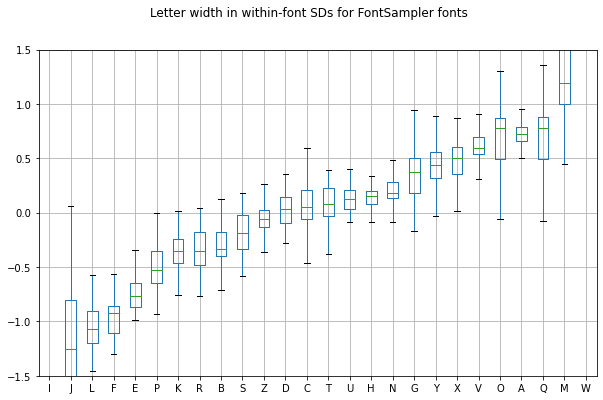

In [102]:
#export

def normalise_glyph_widths(
    glyph_widths: DataFrame,
    std_limit = .1,
    plot = True,
    **plot_args
    ) -> DataFrame:
    """Normalise the glyph widths in the df and filter out fonts where
       the standard deviation as a fraction of the mean is too small."""
    means = glyph_widths.mean(axis=1)
    stds  = glyph_widths.std(axis=1)
    shape = list(glyph_widths.shape)
    shape[1] = shape[1] + 1 # Add one col
    res   = np.empty(shape)
    eps   = 1e-8
    for i in range(len(glyph_widths)):
        mean = means.iloc[i]
        std  = stds.iloc[i] + eps
        res[i] = list((glyph_widths.iloc[i] - mean) / std) + [std / mean]
    res_df = DataFrame(res)
    res_df.columns = list(glyph_widths.columns) + ["font_std"]
    res_df.index = glyph_widths.index
    res_df = res_df[res_df.font_std > std_limit]
    res_df.drop(columns="font_std", inplace=True)
    if plot: plot_glyph_widths(res_df, **plot_args)
    return res_df

def plot_glyph_widths(
    res_df: DataFrame, 
    figsize = (10, 6),
    y_range: Tuple[float, float] = None
    ) -> None:
    """Make a box plot of the glyph widths."""
    l_order = list(res_df.columns)
    l_means = res_df.mean()
    l_order.sort(key=lambda x: l_means[x])
    fig = plt.figure(figsize=figsize)
    ax = res_df[l_order].boxplot(showfliers=False)
    if y_range is not None: ax.set_ylim(*y_range)
    fig.suptitle(f"Letter width in within-font SDs for FontSampler fonts")
    plt.show()

norm_widths = normalise_glyph_widths(glyph_widths, plot=False)
plot_glyph_widths(norm_widths, y_range=(-1.5, 1.5))

Above, we see the within-font normalised widths for each uppercase letter. We can compare the results to our proposed letter-width groups. See also a reanalysis, further below.

* Width, AV
  * Somewhat well established
* Width, BPR
  * B and R are very similar (plus K) but P is narrower
* Width, CGOQ + Width n difference from O, G + Width n difference from O, C
  * O is widest of these and G narrower than O with C even more so. Q is almost equal to O.
* Width, EF + Width n difference from E, F
  * F is clearly narrower than E.
* Width, HNU
  * These three are very much alike in their widths.
* Width, TZ
  * This pair is not well supported by the data.
* Width, XY
  * Well supported.

Let's also have a look at the within-font width ranks of the letters. This does not yield much more insights, except for the rather trivial finding that I is consistently the narrowest letter and M and W the widest two.

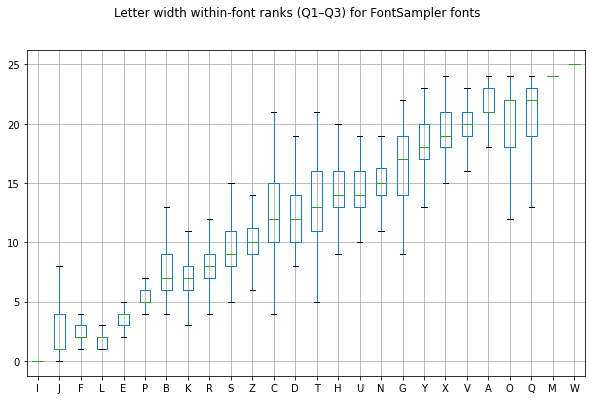

In [97]:
def calc_glyph_width_ranks(
    norm_widths: DataFrame,
    plot = True,
    figsize=(10, 6)
    ) -> DataFrame:
    """Calculate the within-font width orders for each letter in each font
       and plot the orders in a box plot."""
    fonts     = list(norm_widths.index)
    letters   = list(norm_widths.columns)
    n_fonts   = len(fonts)
    n_letters = len(letters)
    letter_ranks = np.empty((n_fonts, n_letters))
    for i in range(n_fonts):
        ord = list(norm_widths.iloc[i].sort_values().index)
        ranks = [ord.index(x) if x in ord else None for x in letters]
        letter_ranks[i] = ranks
    res = DataFrame(letter_ranks)
    res.index   = fonts
    res.columns = letters
    if plot:
        letter_order = list(res.columns)
        medians = res.median()
        letter_order.sort(key=lambda x: medians[x])
        fig = plt.figure(figsize=figsize)
        res[letter_order].boxplot(showfliers=False)
        fig.suptitle(f"Letter width within-font ranks (Q1–Q3) for FontSampler fonts")
        plt.show()
    return res

glyph_ranks = calc_glyph_width_ranks(norm_widths)

Finally, let's check if there are any near-universal pairwise width relations. Let's compare each letter against the others and calculate the percentage of fonts where that letter is narrower than the other. We can also do another calculation to see if there are any nearly-equal-width groups of letters.

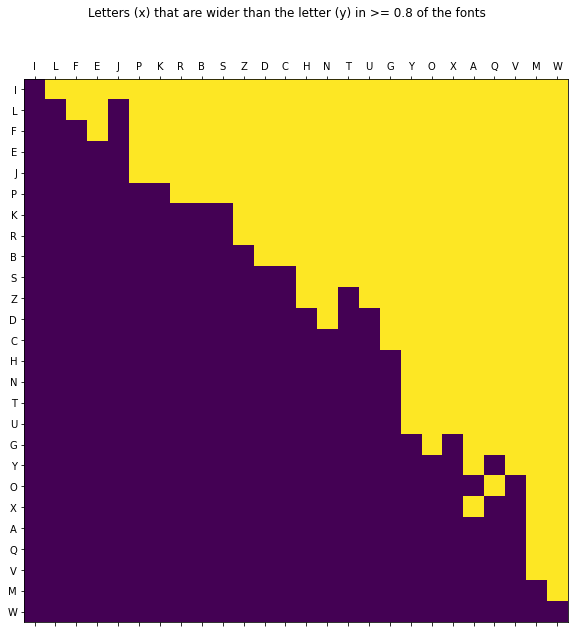

In [156]:
def calc_pairwise_width_relations(
    norm_widths: DataFrame,
    plot = True,
    **plot_args
    ) -> DataFrame:
    """For each letter, calculate the proportion of fonts where it 
       is narrower than every other."""
    fonts     = list(norm_widths.index)
    letters   = list(norm_widths.columns)
    n_fonts   = len(fonts)
    n_letters = len(letters)
    letter_rels = np.zeros((n_letters, n_letters))
    for i in range(n_fonts):
        ord = list(norm_widths.iloc[i].sort_values().index)
        i_ord = [letters.index(x) for x in ord]
        rels = np.zeros((n_letters, n_letters))
        for i, l_i in enumerate(i_ord): rels[l_i, (i + 1):] = 1
        alpha_ord = [ord.index(x) for x in letters]
        rels = rels[:, alpha_ord]
        letter_rels += rels
    res = DataFrame(letter_rels / n_fonts)
    res.columns = res.index = letters
    if plot: plot_pairwise_width_relations(res, **plot_args)
    return res
    
def plot_pairwise_width_relations(
    pairwise_widths: DataFrame,
    limit = .8,
    **plot_args
    ) -> None:
    """Plot the pairwise width relationships produced by
       `calc_pairwise_width_relations` by marking, for each letter,
       the other letters it is narrower than for at least `limit` 
       of the fonts."""
    res = (pairwise_widths - limit + 1e-8).apply(np.ceil) if limit is not None else pairwise_widths.copy()
    letter_order = list(res.index)
    sums = res.sum(axis=1)
    def _by_sum(x): return sums[x]
    letter_order.sort(key=_by_sum, reverse=True)
    res = res[letter_order]
    res.sort_index(key=_by_sum, ascending=False, inplace=True)
    plot_correlation_matrix(data=res,
                            x_labels=letter_order,
                            show_colorbar=limit is None,
                            title=f"Letters (x) that are wider than the letter (y) in >= {limit} of the fonts")

def plot_correlation_matrix(
    data: DataFrame,
    x_labels: list = None,
    y_labels: list = None,
    title: str = None,
    show_colorbar = False,
    figsize = (10, 10)
    ) -> plt.Figure:
    """Plot a correlation matrix."""
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    axim  = ax.matshow(data)
    if x_labels is not None:
        if y_labels is None: y_labels = x_labels
        ax.set_xticks(range(len(x_labels)))
        ax.set_yticks(range(len(y_labels)))
        ax.set_xticklabels(x_labels)
        ax.set_yticklabels(y_labels)
    if title: fig.suptitle(title)
    if show_colorbar: fig.colorbar(axim)
    return fig

# pairwise_widths = calc_pairwise_width_relations(norm_widths, limit=.8)
plot_pairwise_width_relations(pairwise_widths, limit=.8)

This looks more informative with there being at least a clear width hierarchy for most of the letters in 0.8 of the fonts. Finally, let's have a look if there are any natural groups of letters with widths within a small range.

The procedure we'll be using, is:

1. Order the letters in each font by width
2. Iterate over all of the letters while keeping track of the number of letters within the given width range
3. Create a list of all conforming permutations of two or more letters conforming to this limit
4. Finally, calculate the proportion of fonts in which each of the width sets holds

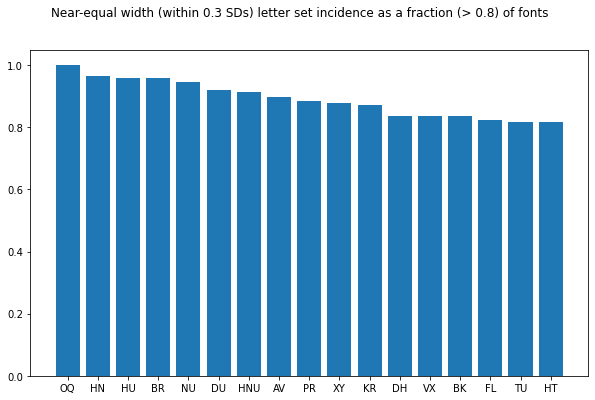

In [205]:
def calc_equal_width_sets(
    norm_widths: DataFrame,
    limit = .2,
    plot = True,
    **plot_args
    ) -> DataFrame:
    """Search the fonts for sets of letters within `limit` SDs of width
       of each other and calculate the fraction of fonts in which that
       relation holds."""
    sets = []
    for i, r in norm_widths.iterrows():
        ord = r.sort_values()
        bfr = []
        for l, w in ord.iteritems():
            cut = None
            if len(bfr) == 0: bfr.append((l, w)); continue
            for j in range(len(bfr)):
                lj, wj = bfr[j]
                if w - wj <= limit: break
                cut = j + 1
                for k in range(1, len(bfr)):
                    combs = combinations([x[0] for x in bfr[(j + 1):]], k)
                    for c in combs: sets.append(set(list(c) + [lj]))
            if cut is not None: bfr = bfr[cut:]
            bfr.append((l, w))
        # Add the remnants of the buffer
        for j in range(len(bfr)):
            lj = bfr[j][0]
            for k in range(1, len(bfr)):
                combs = combinations([x[0] for x in bfr[(j + 1):]], k)
                for c in combs: sets.append(set(list(c) + [lj]))
    res = {}
    for s in sets:
        n = ''.join(sorted(s))
        res[n] = 1 if n not in res else res[n] + 1
    res_df = DataFrame(res.values())
    res_df.columns = ["incidence"]
    res_df.index = res.keys()
    res_df /= len(norm_widths)
    res_df.sort_values(by="incidence", ascending=False, inplace=True)
    if plot: plot_equal_width_sets(res_df, limit, **plot_args)
    return res_df

def plot_equal_width_sets(
    equal_widths: DataFrame,
    width_limit = "unknown",
    incidence_limit = .8,
    figsize = (10, 6)
    ) -> plt.Figure:
    """Plot the incidence statistics for the equal width sets."""
    data = equal_widths[equal_widths.incidence >= incidence_limit]
    fig = plt.figure(figsize=figsize)
    ax = plt.bar(list(data.index), list(data.incidence))
    fig.suptitle(f"Near-equal width (within {width_limit} SDs) letter set incidence as a fraction (> {incidence_limit}) of fonts")
    plt.show()
    return fig
    
equal_widths = calc_equal_width_sets(norm_widths, limit = .3)

With the results in this graph, we can have another look at the equal-width categories we had proposed earlier.

* Width, AV
  * Hold well
* Width, BPR
  * BR and PR hold pairwise
* Width, CGOQ + Width n difference from O, G + Width n difference from O, C
  * OQ is well established. CG differ.
* Width, EF + Width n difference from E, F
  * Differ from each other as expected.
* Width, HNU
  * Holds well
* Width, TZ
  * Not supported
* Width, XY
  * Holds well

In addition to the proposed groups, we also have the following near-equal-width pairs:

DU, KR, DH, VX, BK, FL, TU, HT

## Export

In [29]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 01_fontlearnertests.ipynb.
Converted 02_first_letter_and_optim_tests.ipynb.
Converted 03_vector_models.ipynb.
Converted 04_font_statistics.ipynb.
Converted aifont_core.ipynb.
Converted aifont_fontlearner.ipynb.
Converted aifont_fontsampler.ipynb.
Converted aifont_ocrlearner.ipynb.
Converted index.ipynb.
